# Analyze counts and compute escape scores
This Python Jupyter notebook analyzes the variant counts and looks at mutation coverage and jackpotting.
It then computes an "escape scores" for each variant after grouping by barcode or substitutions as specified in the configuration.

## Set up analysis

This notebook primarily makes use of the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package, and uses [plotnine](https://github.com/has2k1/plotnine) for ggplot2-like plotting syntax:

In [1]:
import collections
import math
import os
import warnings

import Bio.SeqIO

import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy

import pandas as pd

from plotnine import *

import seaborn

import yaml

%matplotlib inline

Set [plotnine](https://github.com/has2k1/plotnine) theme to the gray-grid one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 1.4.3


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [6]:
os.makedirs(config['escape_scores_dir'], exist_ok=True)

Read information about the samples:

In [7]:
samples_df = pd.read_csv(config['barcode_runs_Wuhan_Hu_1'])

## Initialize codon-variant table
Initialize [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) from wildtype gene sequence and the variant counts CSV file.
We will then use the plotting functions of this variant table to analyze the counts per sample:

In [8]:
wt_seqrecord = Bio.SeqIO.read(config['wildtype_sequence_Wuhan_Hu_1'], 'fasta')
geneseq = str(wt_seqrecord.seq)
primary_target = wt_seqrecord.name
print(f"Read sequence of {len(geneseq)} nt for {primary_target} from {config['wildtype_sequence_Wuhan_Hu_1']}")
      
print(f"Initializing CodonVariantTable from gene sequence and {config['variant_counts_Wuhan_Hu_1']}")
      
variants = dms_variants.codonvarianttable.CodonVariantTable.from_variant_count_df(
                geneseq=geneseq,
                variant_count_df_file=config['variant_counts_Wuhan_Hu_1'],
                primary_target=primary_target)
      
print('Done initializing CodonVariantTable.')

Read sequence of 603 nt for Wuhan_Hu_1 from data/wildtype_sequence_Wuhan_Hu_1.fasta
Initializing CodonVariantTable from gene sequence and results/counts/Wuhan_Hu_1/variant_counts.csv.gz
Done initializing CodonVariantTable.


## Sequencing counts per sample
Average counts per variant for each sample.
Note that these are the **sequencing** counts, in some cases they may outstrip the actual number of sorted cells:

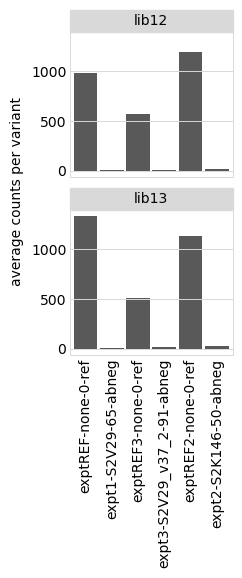

In [9]:
p = variants.plotAvgCountsPerVariant(libraries=variants.libraries,
                                     by_target=False,
                                     orientation='v')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

And the numerical values plotted above:

In [10]:
display(HTML(
 variants.avgCountsPerVariant(libraries=variants.libraries,
                               by_target=False)
 .pivot_table(index='sample',
              columns='library',
              values='avg_counts_per_variant')
 .round(1)
 .to_html()
 ))

library,lib12,lib13
sample,,
exptREF-none-0-ref,986.9,1332.2
expt1-S2V29-65-abneg,5.7,6.1
exptREF3-none-0-ref,575.5,511.2
expt3-S2V29_v37_2-91-abneg,10.5,15.0
exptREF2-none-0-ref,1195.7,1136.2
expt2-S2K146-50-abneg,19.1,25.4


## Mutations per variant
Average number of mutations per gene among all variants of the primary target, separately for each date:

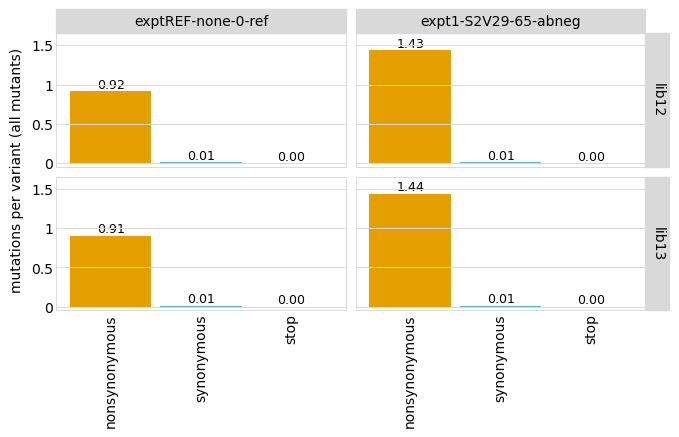

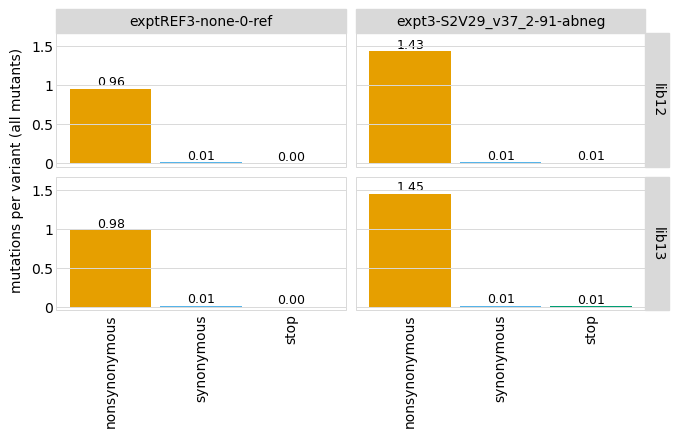

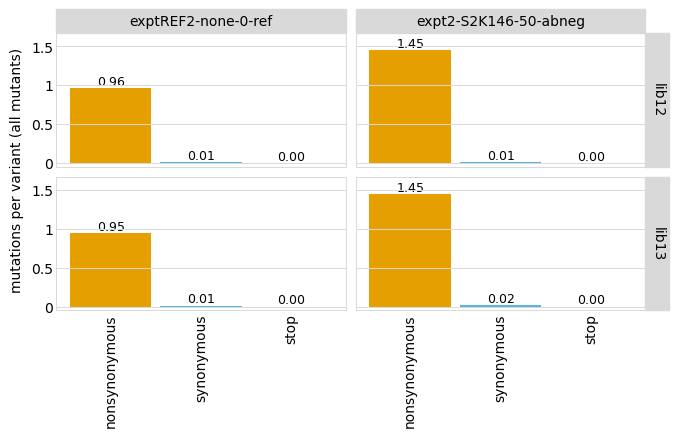

In [11]:
#this plotting is very slow when lots of samples, so for now plots are commented out

for date, date_df in samples_df.groupby('date', sort=False):
   p = variants.plotNumCodonMutsByType(variant_type='all',
                                       orientation='v',
                                       libraries=variants.libraries,
                                       samples=date_df['sample'].unique().tolist(),
                                       widthscale=2)
   p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
   fig = p.draw()
   display(fig)
   plt.close(fig)

Now similar plots but showing mutation frequency across the gene:

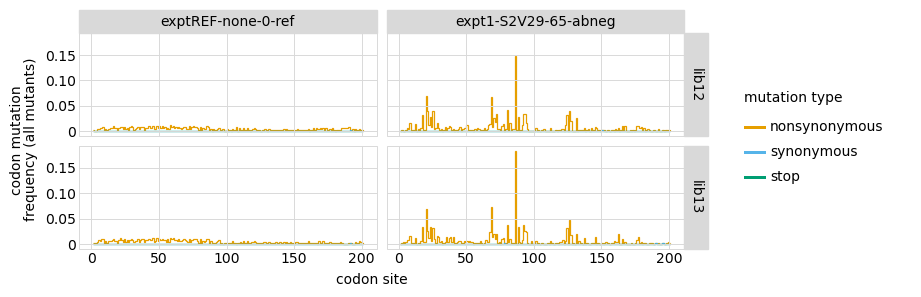

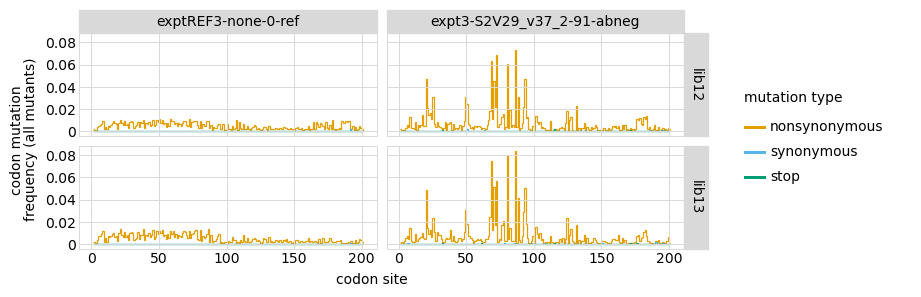

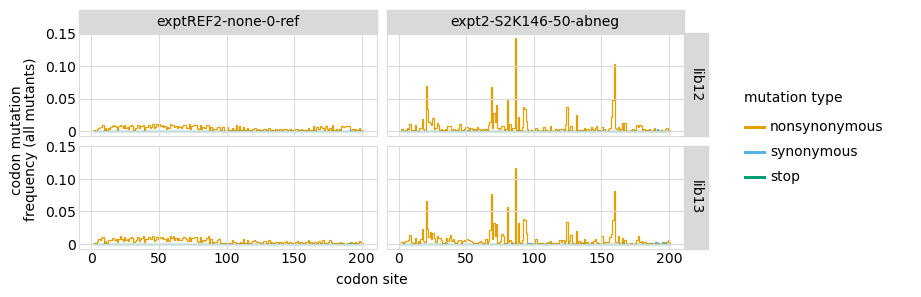

In [12]:
# this plotting is very slow when lots of samples, so for now code commented out

for date, date_df in samples_df.groupby('date', sort=False):
   p = variants.plotMutFreqs(variant_type='all',
                             mut_type='codon',
                             orientation='v',
                             libraries=variants.libraries,
                             samples=date_df['sample'].unique().tolist(),
                             widthscale=1.5)
   fig = p.draw()
   display(fig)
   plt.close(fig)

## Jackpotting and mutation coverage in pre-selection libraries
We look at the distribution of counts in the "reference" (pre-selection) libraries to see if they seem jackpotted (a few variants at very high frequency):

In [13]:
pre_samples_df = samples_df.query('selection == "reference"')

Distribution of mutations along the gene for the pre-selection samples; big spikes may indicate jackpotting:

In [14]:
# this plotting is very slow when lots of samples, so for now code commented out

p = variants.plotMutFreqs(variant_type='all',
                         mut_type='codon',
                         orientation='v',
                         libraries=variants.libraries,
                         samples=pre_samples_df['sample'].unique().tolist(),
                         widthscale=1.5)
_ = p.draw()

How many mutations are observed frequently in pre-selection libraries?
Note that the libraries have been pre-selected for ACE2 binding, so we expect stop variants to mostly be missing.
Make the plot both for all variants and just single-mutant variants:

In [15]:
# this plotting is very slow when lots of samples, so for now code commented out

for variant_type in ['all', 'single']:
   p = variants.plotCumulMutCoverage(
                         variant_type=variant_type,
                         mut_type='aa',
                         orientation='v',
                         libraries=variants.libraries,
                         samples=pre_samples_df['sample'].unique().tolist(),
                         widthscale=1.8,
                         heightscale=1.2)
   _ = p.draw()

Now make a plot showing what number and fraction of counts are for each variant in each pre-selection sample / library.
If some variants constitute a very high fraction, then that indicates extensive bottlenecking:

In [16]:
for ystat in ['frac_counts', 'count']:
    p = variants.plotCountsPerVariant(ystat=ystat,
                                      libraries=variants.libraries,
                                      samples=pre_samples_df['sample'].unique().tolist(),
                                      orientation='v',
                                      widthscale=1.75,
                                      )
    _ = p.draw()

Now make the same plot breaking down by variant class, which enables determination of which types of variants are at high and low frequencies.
For this plot (unlike one above not classified by category) we only show variants of the primary target (not the homologs), and also group synonymous with wildtype in order to reduce number of plotted categories to make more interpretable:

In [17]:
for ystat in ['frac_counts', 'count']:
    p = variants.plotCountsPerVariant(ystat=ystat,
                                      libraries=variants.libraries,
                                      samples=pre_samples_df['sample'].unique().tolist(),
                                      orientation='v',
                                      widthscale=1.75,
                                      by_variant_class=True,
                                      classifyVariants_kwargs={'syn_as_wt': True},
                                      primary_target_only=True,
                                      )
    _ = p.draw()

We also directly look to see what is the variant in each reference library / sample with the highest fraction counts.
Knowing if the highest frequency variant is shared helps determine **where** in the experiment the jackpotting happened:

In [18]:
frac_counts_per_variant = (
        variants.add_frac_counts(variants.variant_count_df)
        .query(f"sample in {pre_samples_df['sample'].unique().tolist()}")
        )

display(HTML(
    frac_counts_per_variant
    .sort_values('frac_counts', ascending=False)
    .groupby(['library', 'sample'])
    .head(n=1)
    .sort_values(['library', 'sample'])
    .set_index(['library', 'sample'])
    [['frac_counts', 'target', 'barcode', 'aa_substitutions', 'codon_substitutions']]
    .round(4)
    .to_html()
    ))

To further where the jackpotting relative to the generation of the reference samples, we plot the correlation among the fraction of counts for the different reference samples.
If the fractions are highly correlated, that indicates that the jackpotting occurred in some upstream step common to the reference samples:

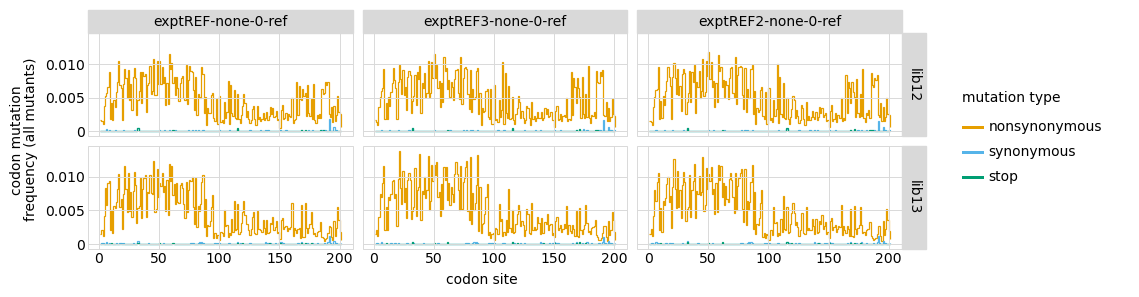

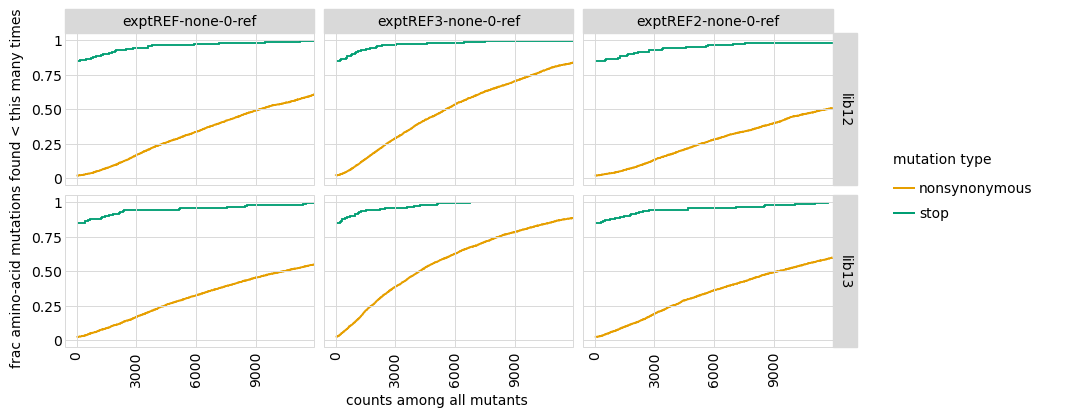

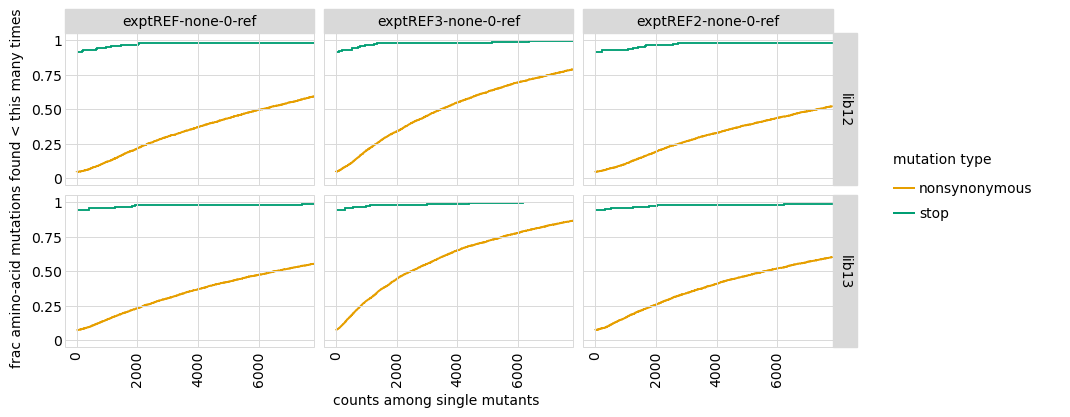

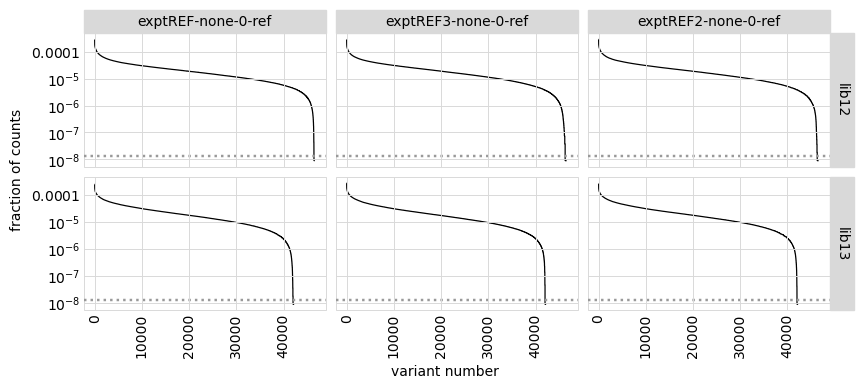

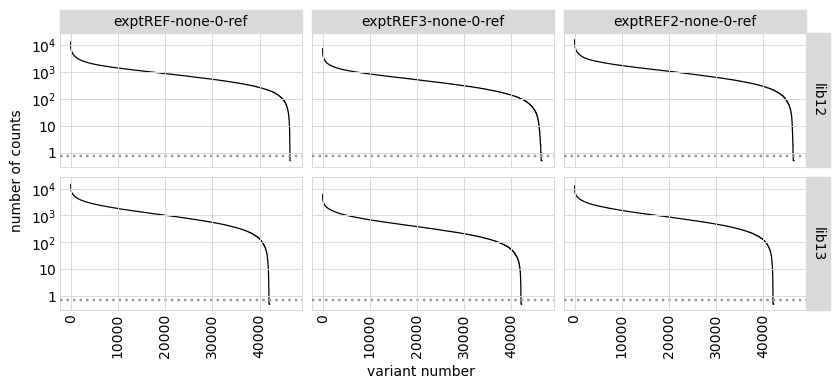

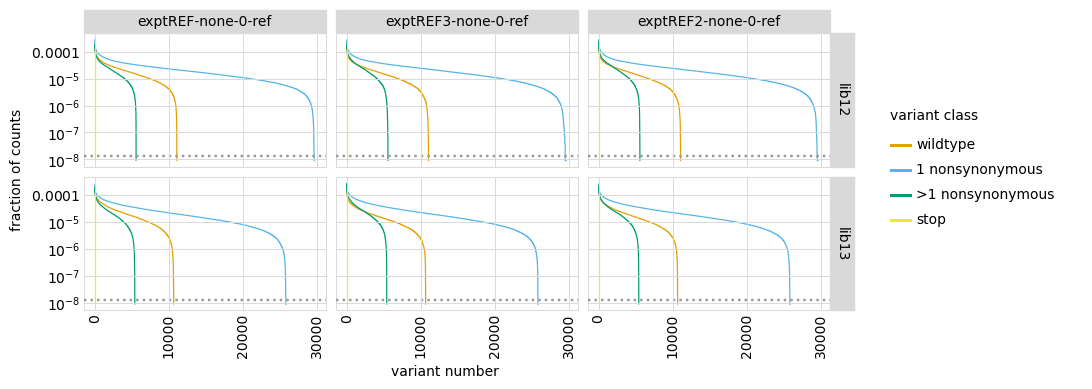

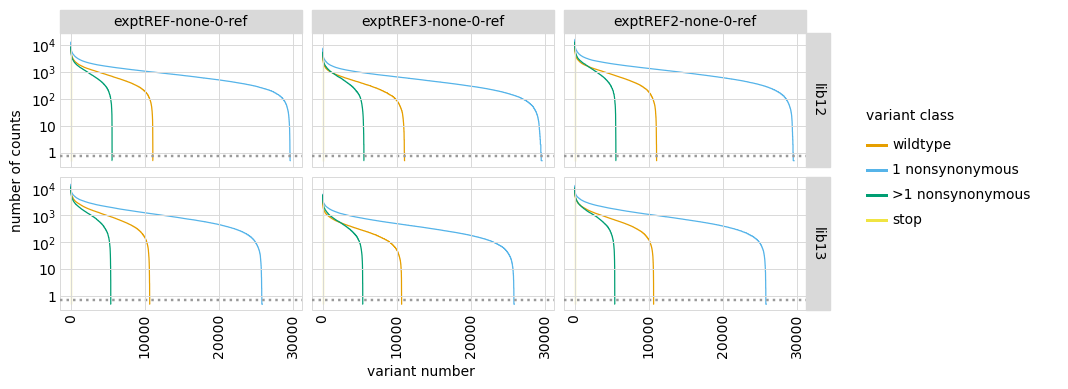

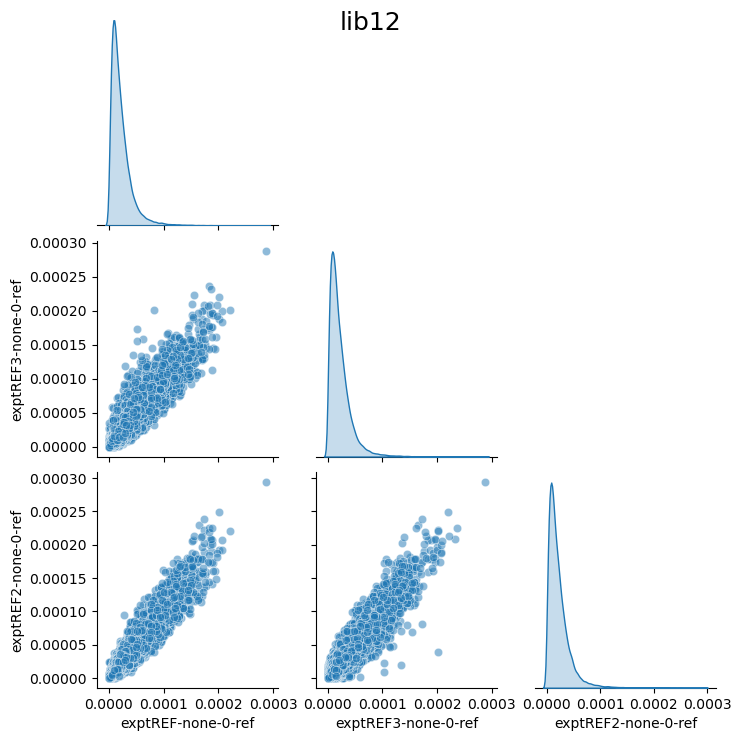

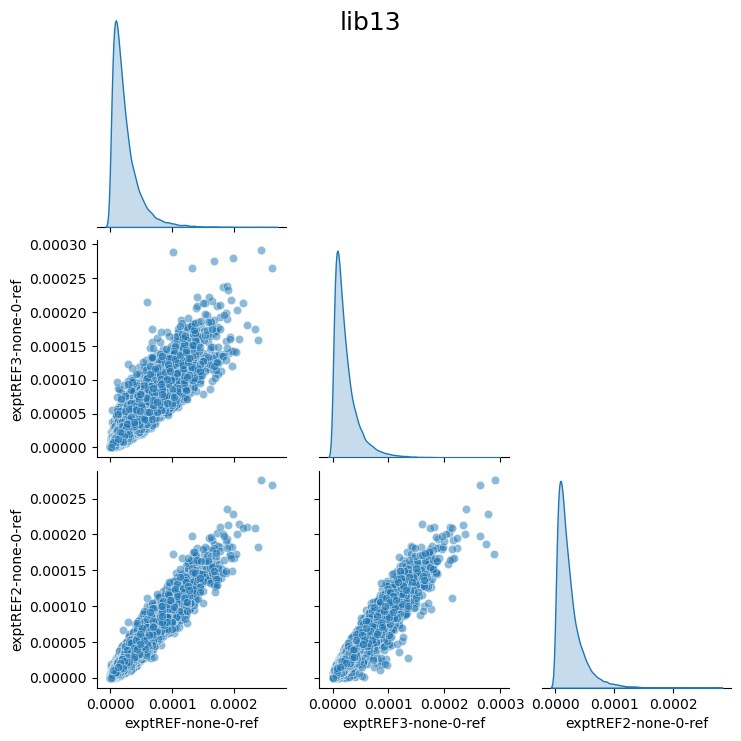

In [19]:
# this code makes a full matrix of scatter plots, but is REALLY SLOW. So for now,
# it is commented out in favor of code that just makes correlation matrix.
for lib, lib_df in frac_counts_per_variant.groupby('library'):
   wide_lib_df = lib_df.pivot_table(index=['target', 'barcode'],
                                    columns='sample',
                                    values='frac_counts')
   g = seaborn.pairplot(wide_lib_df, corner=True, plot_kws={'alpha': 0.5}, diag_kind='kde')
   _ = g.fig.suptitle(lib, size=18)
   plt.show()

## Examine counts for wildtype variants
The type of score we use to quantify escape depends on how well represented wildtype is in the selected libraries.
If wildtype is still well represented, we can use a more conventional functional score that gives differential selection relative to wildtype.
If wildtype is not well represented, then we need an alternative score that does not involve normalizing frequencies to wildtype.

First get average fraction of counts per variant for each variant class:

In [20]:
counts_by_class = (
    variants.variant_count_df
    .pipe(variants.add_frac_counts)
    .pipe(variants.classifyVariants,
          primary_target=variants.primary_target,
          non_primary_target_class='homolog',
          class_as_categorical=True)
    .groupby(['library', 'sample', 'variant_class'])
    .aggregate(avg_frac_counts=pd.NamedAgg('frac_counts', 'mean'))
    .reset_index()
    .merge(samples_df[['sample', 'library', 'date', 'antibody', 'concentration', 'selection']],
           on=['sample', 'library'], validate='many_to_one')
    )

display(HTML(counts_by_class.head().to_html(index=False)))

library,sample,variant_class,avg_frac_counts,date,antibody,concentration,selection
lib12,exptREF-none-0-ref,wildtype,0.000020,221130,none,0,reference
lib12,exptREF-none-0-ref,synonymous,0.000021,221130,none,0,reference
lib12,exptREF-none-0-ref,1 nonsynonymous,0.000022,221130,none,0,reference
lib12,exptREF-none-0-ref,>1 nonsynonymous,0.000023,221130,none,0,reference
lib12,exptREF-none-0-ref,stop,0.000025,221130,none,0,reference


Plot average fraction of all counts per variant for each variant class.
If the values for wildtype are low for the non-reference samples (such as more similar to stop the nonsynonymous), then normalizing by wildtype in calculating scores will probably not work well as wildtype is too depleted:

In [21]:
min_frac = 1e-7  # plot values < this as this

p = (ggplot(counts_by_class
            .assign(avg_frac_counts=lambda x: numpy.clip(x['avg_frac_counts'], min_frac, None))
            ) +
     aes('avg_frac_counts', 'sample', color='selection') +
     geom_point(size=2) +
     scale_color_manual(values=CBPALETTE[1:]) +
     facet_grid('library ~ variant_class') +
     scale_x_log10() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2.5 * counts_by_class['variant_class'].nunique(),
                        0.2 * counts_by_class['library'].nunique() * 
                        counts_by_class['sample'].nunique())
           ) +
     geom_vline(xintercept=min_frac, linetype='dotted', color=CBPALETTE[3])
     )

_ = p.draw()

## Compute escape scores
We use the escape score metric, which does **not** involve normalizing to wildtype and so isn't strongly affected by low wildtype counts.
We compute the scores using the method [dms_variants.codonvarianttable.CodonVariantTable.escape_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html?highlight=escape_scores#dms_variants.codonvarianttable.CodonVariantTable.escape_scores).

First, define what samples to compare for each calculation, matching each post-selection (escape) to the pre-selection (reference) sample on the same date:

In [22]:
score_sample_df = (
    samples_df
    .query('selection == "escape"')
    .rename(columns={'sample': 'post_sample',
                     'number_cells': 'pre_cells_sorted'})
    .merge(samples_df
           .query('selection == "reference"')
           [['sample', 'library', 'date', 'number_cells']]
           .rename(columns={'sample': 'pre_sample',
                            'number_cells': 'post_cells_sorted'}),
           how='left', on=['date', 'library'], validate='many_to_one',
           )
    .assign(name=lambda x: x['antibody'] + '_' + x['concentration'].astype(str))
    # add dates to names where needed to make unique
    .assign(n_libs=lambda x: x.groupby(['name', 'date'])['pre_sample'].transform('count'))
    .sort_values(['name', 'date', 'n_libs'], ascending=False)
    .assign(i_name=lambda x: x.groupby(['library', 'name'], sort=False)['pre_sample'].cumcount(),
            name=lambda x: x.apply(lambda r: r['name'] + '_' + str(r['date']) if r['i_name'] > 0 else r['name'],
                                   axis=1),
            )
    .sort_values(['antibody', 'concentration', 'library', 'i_name'])
    # get columns of interest
    [['name', 'library', 'antibody', 'concentration', 'date',
      'pre_sample', 'post_sample', 'frac_escape', 'pre_cells_sorted', 'post_cells_sorted']]
    )

assert len(score_sample_df.groupby(['name', 'library'])) == len(score_sample_df)

print(f"Writing samples used to compute escape scores to {config['escape_score_samples_Wuhan_Hu_1']}\n")
score_sample_df.to_csv(config['escape_score_samples_Wuhan_Hu_1'], index=False)

display(HTML(score_sample_df.to_html(index=False)))

Writing samples used to compute escape scores to results/escape_scores/samples_Wuhan_Hu_1.csv



name,library,antibody,concentration,date,pre_sample,post_sample,frac_escape,pre_cells_sorted,post_cells_sorted
S2K146_50,lib12,S2K146,50,230512,exptREF2-none-0-ref,expt2-S2K146-50-abneg,0.0093,37200.0,NaN
S2K146_50,lib13,S2K146,50,230512,exptREF2-none-0-ref,expt2-S2K146-50-abneg,0.0160,64000.0,NaN
S2V29_65,lib12,S2V29,65,221130,exptREF-none-0-ref,expt1-S2V29-65-abneg,0.0136,54400.0,NaN
S2V29_65,lib13,S2V29,65,221130,exptREF-none-0-ref,expt1-S2V29-65-abneg,0.0128,51200.0,NaN
S2V29_v37_2_91,lib12,S2V29_v37_2,91,230613,exptREF3-none-0-ref,expt3-S2V29_v37_2-91-abneg,0.0410,164000.0,NaN
S2V29_v37_2_91,lib13,S2V29_v37_2,91,230613,exptREF3-none-0-ref,expt3-S2V29_v37_2-91-abneg,0.0630,252000.0,NaN


Compute the escape scores for variants of the primary target and classify the variants:

In [23]:
print(f"Computing escape scores for {primary_target} variants using {config['escape_score_type']} "
      f"score type with a pseudocount of {config['escape_score_pseudocount']} and "
      f"an escape fraction floor {config['escape_score_floor_E']}, an escape fraction ceiling "
      f"{config['escape_score_ceil_E']}, and grouping variants by {config['escape_score_group_by']}.")

escape_scores = (variants.escape_scores(score_sample_df,
                                        score_type=config['escape_score_type'],
                                        pseudocount=config['escape_score_pseudocount'],
                                        floor_E=config['escape_score_floor_E'],
                                        ceil_E=config['escape_score_ceil_E'],
                                        by=config['escape_score_group_by'],
                                        )
                 .query('target == @primary_target')
                 .pipe(variants.classifyVariants,
                       primary_target=variants.primary_target,
                       syn_as_wt=(config['escape_score_group_by'] == 'aa_substitutions'),
                       )
                 )
print('Here are the first few lines of the resulting escape scores:')
display(HTML(escape_scores.head().to_html(index=False)))

Computing escape scores for Wuhan_Hu_1 variants using frac_escape score type with a pseudocount of 0.5 and an escape fraction floor 0, an escape fraction ceiling 1, and grouping variants by barcode.
Here are the first few lines of the resulting escape scores:


name,target,library,pre_sample,post_sample,barcode,score,score_var,pre_count,post_count,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions,variant_class
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,GAAACAAATTTCTATA,0.001784,6.199738e-08,16369,51,GTA52GGT,1,V52G,1,1 nonsynonymous
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,TGATGCCGTAACTGTC,0.000020,8.347569e-10,13879,0,CGT127GAT,1,R127D,1,1 nonsynonymous
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,CGGATCTAAACTGCCG,0.000021,9.152003e-10,13255,0,TTC17GCT TAC35ATG,2,F17A Y35M,2,>1 nonsynonymous
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,ATCCATGTGACTCAAT,0.001713,7.646780e-08,12743,38,GCA22TAT CTT183GCT,2,A22Y L183A,2,>1 nonsynonymous
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,TTGCTTGACTACATCA,0.000023,1.017825e-09,12569,0,AAC4TTT GTC173AAA,2,N4F V173K,2,>1 nonsynonymous


## Apply pre-selection count filter to variant escape scores
Now determine a pre-selection count filter in order to flag for removal variants with counts that are so low that the estimated score is probably noise.
We know that stop codons should be largely purged pre-selection, and so the counts for them are a good indication of the "noise" threshold.
We therefore set the filter using the number of pre-selection counts for the stop codons.

To do this, we first compute the number of pre-selection counts for stop-codon variants at various quantiles and look at these.
We then take the number of pre-selection counts at the specified quantile as the filter cutoff, and filter scores for all variants with pre-selection counts less than this filter cutoff:

NOTE, since we didn't pre-sort this library, this is not the appropriate method. This has historically beena round 100, so we'll just apply a filter of 100.

In [24]:
filter_precount = config['escape_score_precount_filter']

print(f"\nSetting the pre-count filter cutoff to the absolute value of {config['escape_score_precount_filter']}")


Setting the pre-count filter cutoff to the absolute value of 100


Apply the filter to the escape scores, so that scores that fail the pre-selection count filter are now marked with `pass_pre_count_filter` of `False`:

In [25]:
escape_scores = (
    escape_scores
    .assign(pass_pre_count_filter=lambda x: x['pre_count'] >= config['escape_score_precount_filter'])
    )
escape_scores.head()

,name,target,library,pre_sample,post_sample,barcode,score,score_var,pre_count,post_count,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions,variant_class,pass_pre_count_filter
0,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,GAAACAAATTTCTATA,0.001784,6.199738e-08,16369,51,GTA52GGT,1,V52G,1,1 nonsynonymous,True
1,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,TGATGCCGTAACTGTC,0.000020,8.347569e-10,13879,0,CGT127GAT,1,R127D,1,1 nonsynonymous,True
2,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,CGGATCTAAACTGCCG,0.000021,9.152003e-10,13255,0,TTC17GCT TAC35ATG,2,F17A Y35M,2,>1 nonsynonymous,True
3,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,ATCCATGTGACTCAAT,0.001713,7.646780e-08,12743,38,GCA22TAT CTT183GCT,2,A22Y L183A,2,>1 nonsynonymous,True
4,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,TTGCTTGACTACATCA,0.000023,1.017825e-09,12569,0,AAC4TTT GTC173AAA,2,N4F V173K,2,>1 nonsynonymous,True


## Apply ACE2-binding / expression filter to variant mutations
We also used deep mutational scanning to estimate how each mutation affected ACE2 binding and expression in the B.1.351 background.
Here we flag for removal any variants of the primary target that have (or have mutations) that were measured to decrease ACE2-binding or expression beyond a minimal threshold, in order to avoid these variants muddying the signal as spurious escape mutants.

To do this, we first determine all mutations that do / do-not having binding that exceeds the thresholds.

Note that because we are working on this serum-mapping project at the same time as we are working on the ACE2-binding / RBD-expression project, the scores will be preliminary until all final analyses have been done on the DMS project end. So, we will allow either preliminary or "final" measurements to be used. 

In [26]:
mut_bind_expr_file = config['mut_bind_expr']
    
print(f"Reading ACE2-binding and expression for mutations from {mut_bind_expr_file}, "
      f"and filtering for variants that have single mutations that "
      f"only have mutations with binding >={config['escape_score_min_bind_mut_Wuhan_Hu_1']} and "
      f"expression >={config['escape_score_min_expr_mut_Wuhan_Hu_1']}.")

mut_bind_expr = (pd.read_csv(mut_bind_expr_file)
                 .query("target == 'Wuhan-Hu-1'")
                 # need to add back the offset numbering for some silly, circuitous reason 
                 .assign(RBD_site=lambda x: x['position']-config['site_number_offset'] ,
                         RBD_mutation=lambda x: x['wildtype']+x['RBD_site'].astype(str)+x['mutant']
                        )
                )

print('Here is what that dataframe looks like:')

display(HTML(mut_bind_expr.query('delta_bind > -2.5').head().to_html(index=False)))

Reading ACE2-binding and expression for mutations from results/prior_DMS_data/mutant_ACE2binding_expression.csv, and filtering for variants that have single mutations that only have mutations with binding >=-3.0 and expression >=-1.25.
Here is what that dataframe looks like:


target,wildtype,position,mutant,mutation,bind,delta_bind,n_bc_bind,n_libs_bind,bind_rep1,bind_rep2,bind_rep3,expr,delta_expr,n_bc_expr,n_libs_expr,expr_rep1,expr_rep2,RBD_site,RBD_mutation
Wuhan-Hu-1,N,331,A,N331A,8.93,0.01,2,1,8.93,NaN,NaN,10.40,0.24,1,1,10.40,NaN,1,N1A
Wuhan-Hu-1,N,331,C,N331C,8.56,-0.37,5,2,8.62,8.51,NaN,9.94,-0.21,3,2,9.67,10.20,1,N1C
Wuhan-Hu-1,N,331,D,N331D,8.99,0.06,5,2,9.03,8.95,NaN,10.11,-0.03,5,2,10.25,9.98,1,N1D
Wuhan-Hu-1,N,331,E,N331E,9.04,0.11,6,2,9.03,9.05,NaN,9.94,-0.20,4,2,9.90,9.99,1,N1E
Wuhan-Hu-1,N,331,F,N331F,8.76,-0.17,5,2,8.61,8.91,NaN,9.91,-0.24,4,2,10.04,9.78,1,N1F


In [27]:
assert mut_bind_expr['RBD_mutation'].nunique() == len(mut_bind_expr)
for prop in ['bind', 'expr']:
    muts_adequate = set(mut_bind_expr
                        .query(f"delta_{prop} >= {config[f'escape_score_min_{prop}_mut_Wuhan_Hu_1']}")
                        ['RBD_mutation']
                        )
    print(f"{len(muts_adequate)} of {len(mut_bind_expr)} mutations have adequate {prop}.")
    escape_scores[f"muts_pass_{prop}_filter"] = (
        escape_scores
        ['aa_substitutions']
        .map(lambda s: set(s.split()).issubset(muts_adequate))
        )

# annotate as passing overall filter if passes all mutation and binding filters:
escape_scores['pass_ACE2bind_expr_filter'] = (
        escape_scores['muts_pass_bind_filter'] &
        escape_scores['muts_pass_expr_filter'] 
        )

display(HTML(escape_scores.query('not pass_ACE2bind_expr_filter & variant_class != "stop"').head().to_html(index=False)))

3582 of 4221 mutations have adequate bind.
3086 of 4221 mutations have adequate expr.


name,target,library,pre_sample,post_sample,barcode,score,score_var,pre_count,post_count,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions,variant_class,pass_pre_count_filter,muts_pass_bind_filter,muts_pass_expr_filter,pass_ACE2bind_expr_filter
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,GAAACAAATTTCTATA,0.001784,6.199738e-08,16369,51,GTA52GGT,1,V52G,1,1 nonsynonymous,True,True,False,False
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,TGATGCCGTAACTGTC,0.000020,8.347569e-10,13879,0,CGT127GAT,1,R127D,1,1 nonsynonymous,True,True,False,False
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,CGGATCTAAACTGCCG,0.000021,9.152003e-10,13255,0,TTC17GCT TAC35ATG,2,F17A Y35M,2,>1 nonsynonymous,True,True,False,False
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,ATCCATGTGACTCAAT,0.001713,7.646780e-08,12743,38,GCA22TAT CTT183GCT,2,A22Y L183A,2,>1 nonsynonymous,True,True,False,False
S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,GAAACCATCGATATTC,0.000023,1.019934e-09,12556,0,GTA52AGA,1,V52R,1,1 nonsynonymous,True,True,False,False


Print the number of mutations that pass RBD bind, RBD expression, and are not to sites that are disulfide bonds (if specified in config) 

In [28]:
# if we are excluding all cysteines to remove spurious mutations that break disulfide bonds:
if config['exclude_cysteines']:
    print("Here are the number of mutations that pass the bind, express, and disulfide filters:")
    print(len(mut_bind_expr
              .assign(pass_cysteine_filter=lambda x: x['mutation'].str[0] != "C")
              .query(f"delta_bind >= {config[f'escape_score_min_bind_mut_Wuhan_Hu_1']} & \
                       delta_expr >= {config[f'escape_score_min_expr_mut_Wuhan_Hu_1']} & \
                       pass_cysteine_filter")
             ))
    print("There are these many possible mutations (excluding wildtype and disulfides!):")
    print(mut_bind_expr.query('wildtype!="C"')['position'].nunique()*19
         )

else:
    print("Here are the number of mutations that pass the bind and express filters:")
    print(len(mut_bind_expr
              .assign(pass_cysteine_filter=lambda x: x['mutation'].str[0] != "C")
              .query(f"delta_bind >= {config[f'escape_score_min_bind_mut_Wuhan_Hu_1']} & \
                       delta_expr >= {config[f'escape_score_min_expr_mut_Wuhan_Hu_1']}")
             ))
    print("There are these many possible mutations (excluding wildtype!):")
    print(mut_bind_expr['position'].nunique()*19
         )

Here are the number of mutations that pass the bind, express, and disulfide filters:
2820
There are these many possible mutations (excluding wildtype and disulfides!):
3667


In [29]:
print('These are the sites that are involved in disulfide bonds:')
print(mut_bind_expr.query('wildtype=="C"')['position'].unique())

These are the sites that are involved in disulfide bonds:
[336 361 379 391 432 480 488 525]


In [30]:
frac_ACE2bind_expr_pass_filter = (
    escape_scores
    .query('pass_pre_count_filter == True')
    [['pre_sample', 'library', 'target', config['escape_score_group_by'],
      'pre_count', 'pass_ACE2bind_expr_filter', 'variant_class']]
    .drop_duplicates()
    .groupby(['pre_sample', 'library', 'variant_class'], observed=True)
    .aggregate(n_variants=pd.NamedAgg('pass_ACE2bind_expr_filter', 'count'),
               n_pass_filter=pd.NamedAgg('pass_ACE2bind_expr_filter', 'sum')
               )
    .reset_index()
    .assign(frac_pass_filter=lambda x: x['n_pass_filter'] / x['n_variants'],
            pre_sample=lambda x: pd.Categorical(x['pre_sample'], x['pre_sample'].unique(), ordered=True).remove_unused_categories())
    )

p = (ggplot(frac_ACE2bind_expr_pass_filter) +
     aes('variant_class', 'frac_pass_filter', fill='variant_class') +
     geom_bar(stat='identity') +
     facet_grid('library ~ pre_sample') +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(3.3 * frac_ACE2bind_expr_pass_filter['pre_sample'].nunique(),
                        2 * frac_ACE2bind_expr_pass_filter['library'].nunique()),
           panel_grid_major_x=element_blank(),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     expand_limits(y=(0, 1))
     )

_ = p.draw()

## Examine and write escape scores
Plot the distribution of escape scores across variants of different classes **among those that pass both the pre-selection count filter and the ACE2-binding / expression filter**.
If things are working correctly, we don't expect escape in wildtype (or synonymous variants), but do expect escape for some small fraction of nonsynymous variants.
Also, we do not plot the scores for the stop codon variant class, as most stop-codon variants have already been filtered out so this category is largely noise:

In [31]:
nfacets = len(escape_scores.groupby(['library', 'name']).nunique())
ncol = min(8, nfacets)
nrow = math.ceil(nfacets / ncol)

df = (escape_scores
      .query('(pass_pre_count_filter == True) & (pass_ACE2bind_expr_filter == True)')
      .query('variant_class != "stop"')
      )
     
p = (ggplot(df) +
     aes('variant_class', 'score', color='variant_class') +
     geom_boxplot(outlier_size=1.5, outlier_alpha=0.1) +
     facet_wrap('~ name + library', ncol=ncol) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2.35 * ncol, 3 * nrow),
           panel_grid_major_x=element_blank(),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     scale_color_manual(values=CBPALETTE[1:])
     )

_ = p.draw()

Also, we want to see how much the high escape scores are correlated with simple coverage.
To do this, we plot the correlation between escape score and pre-selection count just for the nonsynonymous variants (which are the ones that we expect to have true escape).
The plots below have a lot of overplotting, but are still sufficient to test of the score is simply correlated with the pre-selection counts or not.
The hoped for result is that the escape score doesn't appear to be strongly correlated with pre-selection counts:

In [32]:
p = (ggplot(escape_scores
            .query('pass_pre_count_filter == True')
            .query('(pass_pre_count_filter == True) & (pass_ACE2bind_expr_filter == True)')
            .query('variant_class=="1 nonsynonymous"')
            ) +
     aes('pre_count', 'score') +
     geom_point(alpha=0.1, size=1) +
     facet_wrap('~ name + library', ncol=ncol) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2.35 * ncol, 2.35 * nrow),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     scale_color_manual(values=CBPALETTE[1:]) +
     scale_x_log10()
     )

_ = p.draw()

Write the escape scores to a file:

In [33]:
print(f"Writing escape scores for Wuhan_Hu_1 SSM to {config['escape_scores_Wuhan_Hu_1']}")
escape_scores.to_csv(config['escape_scores_Wuhan_Hu_1'], index=False, float_format='%.4g')

Writing escape scores for Wuhan_Hu_1 SSM to results/escape_scores/scores_Wuhan_Hu_1.csv


### Now we will also remove anything that did not pass all the filters above. 

In [34]:
escape_scores_primary = (escape_scores
                         .query('(pass_pre_count_filter == True) & (pass_ACE2bind_expr_filter == True)')
                        )

display(HTML(escape_scores_primary.head().to_html()))
print(f"Read {len(escape_scores_primary)} scores.")

,name,target,library,pre_sample,post_sample,barcode,score,score_var,pre_count,post_count,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions,variant_class,pass_pre_count_filter,muts_pass_bind_filter,muts_pass_expr_filter,pass_ACE2bind_expr_filter
4,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,TTGCTTGACTACATCA,0.000023,1.017825e-09,12569,0,AAC4TTT GTC173AAA,2,N4F V173K,2,>1 nonsynonymous,True,True,True,True
7,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,CGTAACATTTACATAT,0.000023,1.059383e-09,12320,0,ACT15TAT,1,T15Y,1,1 nonsynonymous,True,True,True,True
15,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,CTCACTCACCAATACG,0.000025,1.204713e-09,11553,0,TTC44AGA,1,F44R,1,1 nonsynonymous,True,True,True,True
20,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,GCCATGCTATTGCGTT,0.000026,1.301997e-09,11113,0,AGT29TTG,1,S29L,1,1 nonsynonymous,True,True,True,True
21,S2K146_50,Wuhan_Hu_1,lib12,exptREF2-none-0-ref,expt2-S2K146-50-abneg,CTGCACTGGTGGTACA,0.000026,1.342518e-09,10944,0,ACT15CAT,1,T15H,1,1 nonsynonymous,True,True,True,True


Read 192358 scores.


### Count number of barcodes per mutation and remove variants with >1 amino acid substitution
Also add the number of barocdes per mutation to the `escape_scores` dataframe and plot this. 
But first see how many variants there are with >1 mutation, and query the dataframe to look at them qualitatively. 

In [35]:
p = (ggplot(escape_scores_primary) +
     aes('n_aa_substitutions', fill='variant_class') +
     geom_bar() +
     facet_wrap('~library + pre_sample', ncol=5) +
     theme(
#            figure_size=(3.3 * escape_scores_primary['pre_sample'].nunique(),
#                         2 * escape_scores_primary['library'].nunique()),
         figure_size=(12, 4),
           panel_grid_major_x=element_blank(),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     expand_limits(y=(0, 1))
     )

_ = p.draw()

### Filter dataframe on single mutations that are present in at least `n` number of variants (specified in `config.yaml` file)
Now see how many `n_single_mut_measurements` there are for each variant:

In [36]:
print(f'Remove anything with fewer than {config["escape_frac_min_single_mut_measurements"]} single mutant measurements (barcodes)')

raw_avg_single_mut_scores = (
    escape_scores_primary
    .query('n_aa_substitutions == 1')
    .rename(columns={'name': 'selection',
                     'aa_substitutions': 'mutation'})
    .groupby(['selection', 'library', 'mutation'])
    .aggregate(raw_single_mut_score=pd.NamedAgg('score', 'mean'),
               n_single_mut_measurements=pd.NamedAgg('barcode', 'count')
              )
    .assign(sufficient_measurements=lambda x: (
                (x['n_single_mut_measurements'] >= config['escape_frac_min_single_mut_measurements'])))
    .reset_index()
    )

# remove mutations with insufficient measurements
effects_df = (raw_avg_single_mut_scores
              .query('sufficient_measurements == True')
              .drop(columns='sufficient_measurements')
              )

# some error checks
assert len(effects_df) == len(effects_df.drop_duplicates()), 'duplicate rows in `effects_df`'
assert all(effects_df['raw_single_mut_score'].notnull() | (effects_df['n_single_mut_measurements'] == 0))

display(HTML(effects_df.head().to_html()))

Remove anything with fewer than 2 single mutant measurements (barcodes)


,selection,library,mutation,raw_single_mut_score,n_single_mut_measurements
0,S2K146_50,lib12,A105C,0.000272,6
1,S2K146_50,lib12,A105F,0.000265,3
3,S2K146_50,lib12,A105I,0.000454,3
4,S2K146_50,lib12,A105M,0.000604,5
5,S2K146_50,lib12,A105S,0.000598,6


### Should we exclude mutations for which the wildtype identity is a cysteine?
These would be mutations that break disulfide bonds (unless there is an unpaired cysteine in the protein that does not form a disulfide bond, of course). 
Note that this approach would not work well for something like the SARS-CoV-2 NTD, where it has been documented (by the Veesler lab) that mutations in the B.1.427/429 (epislon) variant can rearrange disulfide bonds, leading to major structural rearrangements in the NTD, and yet an apparently fully functional spike. 

If we are excluding cysteines, do that now:

In [37]:
# if we are excluding all cysteines to remove spurious mutations that break disulfide bonds:
if config['exclude_cysteines']:
    print(f'Excluding mutations where the wildtype identity is a cysteine')
    effects_df = effects_df.assign(pass_cysteine_filter=lambda x: x['mutation'].str[0] != "C",
                                  )
    disulfides_to_drop = effects_df.query('pass_cysteine_filter==False')['mutation'].unique()
    print(f'Specifically, excluding: {disulfides_to_drop}')
    effects_df=effects_df.query('pass_cysteine_filter').drop(columns='pass_cysteine_filter')

else:
    print(f'Retaining mutations where the wildtype identity is a cysteine')

Excluding mutations where the wildtype identity is a cysteine
Specifically, excluding: ['C102I' 'C158F' 'C158M' 'C158S' 'C158T' 'C195A' 'C195D' 'C195E' 'C195F'
 'C195H' 'C195K' 'C195L' 'C195M' 'C195P' 'C195Q' 'C195R' 'C195S' 'C195T'
 'C195V' 'C195W' 'C195Y' 'C31E' 'C31F' 'C31G' 'C31H' 'C31I' 'C31K' 'C31L'
 'C31N' 'C31P' 'C31Q' 'C31R' 'C31S' 'C31T' 'C31V' 'C31W' 'C49W' 'C61A'
 'C61D' 'C61E' 'C61F' 'C61G' 'C61H' 'C61I' 'C61K' 'C61L' 'C61M' 'C61N'
 'C61P' 'C61Q' 'C61R' 'C61S' 'C61T' 'C61V' 'C61W' 'C61Y' 'C6A' 'C6D' 'C6E'
 'C6F' 'C6G' 'C6H' 'C6I' 'C6M' 'C6N' 'C6Q' 'C6S' 'C6V' 'C6W' 'C6Y' 'C158K'
 'C158Q' 'C195G' 'C195I' 'C195N' 'C31A' 'C31D' 'C31M' 'C6L' 'C6T']


We need to compute the escape scores (calculated as [here](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html?highlight=escape_scores#dms_variants.codonvarianttable.CodonVariantTable.escape_scores)) back to escape fractions. We define a function to do this depending on the score type:

In [38]:
def score_to_frac(score):
    """Convert escape score to escape fraction."""
    if pd.isnull(score):
        return pd.NA
    floor = config['escape_score_floor_E']
    ceil = config['escape_score_ceil_E']
    if config['escape_score_type'] == 'frac_escape':
        return min(ceil, max(floor, score))  # just the score after applying ceiling and floor
    elif config['escape_score_type'] == 'log_escape':
        # convert score back to fraction, apply ceiling, then re-scale so floor is 0
        frac = 2**score
        frac = min(ceil, max(floor, frac))
        frac = (frac - floor) / (ceil - floor)
        return frac
    else:
        raise ValueError(f"invalid `escape_score_type` of {config['escape_score_type']}")

effects_df = (
    effects_df
    .assign(
            mut_escape_frac_single_mut=lambda x: x['raw_single_mut_score'].map(score_to_frac),
            )
    )

### Average the escape score across all barcodes of the same mutation, for each library, and the average of both libraries. 
Add rows that are the average of the two libraries for the fraction escape for all mutations that are present in both libraries (and if in just one library, the value in that or purge depending on config values printed here), the number of libraries each mutation is measured in, and the sum of the statistics giving the number of measurements:

In [39]:
min_libs = config['escape_frac_avg_min_libraries']
min_single = config['escape_frac_avg_min_single']
print(f"Only taking average of mutations with escape fractions in >={min_libs} libraries "
      f"or with >={min_single} single-mutant measurements total.")

effects_df = (
    effects_df
    .query('library != "average"')  # git rid of averages if already there
    .assign(nlibs=1)
    .append(effects_df
            .query('library != "average"')
            .groupby(['selection', 'mutation'])
            .aggregate(nlibs=pd.NamedAgg('library', 'count'),
                       mut_escape_frac_single_mut=pd.NamedAgg('mut_escape_frac_single_mut',
                                                              lambda s: s.mean(skipna=True)),
                       n_single_mut_measurements=pd.NamedAgg('n_single_mut_measurements', 'sum'),
                       )
            .query('(nlibs >= @min_libs) or (n_single_mut_measurements >= @min_single)')
            .assign(library="average")
            .reset_index(),
            ignore_index=True, sort=False,
            )
    )

print(len(effects_df.query('nlibs>1')))
print(len(effects_df.query('nlibs==1')))

Only taking average of mutations with escape fractions in >=2 libraries or with >=2 single-mutant measurements total.
5749
15078


Plot the correlations of the escape fractions among the two libraries for all selections performed on both libraries. 

In [40]:
libraries = [lib for lib in effects_df['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

# wide data frame with each library's score in a different column
effects_df_wide = (
    effects_df
    .query('library != "average"')
    .query(f"n_single_mut_measurements >= 1")
    # just get selections with 2 libraries
    .assign(nlibs=lambda x: x.groupby('selection')['library'].transform('nunique'))
    .query('nlibs == 2')
    # now make columns for each library, only keep mutants with scores for both libs
    [['selection', 'mutation', 'library', 'mut_escape_frac_single_mut']]
    .pivot_table(index=['selection', 'mutation'],
                 columns='library',
                 values='mut_escape_frac_single_mut',
                 aggfunc='first')
    .reset_index()
    .dropna(axis=0)
    )

# correlations between libraries
corrs = (
    effects_df_wide
    .groupby('selection')
    [libraries]
    .corr(method='pearson')
    .reset_index()
    .query('library == @libraries[0]')
    .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
    [['selection', 'correlation']]
    # add number of mutations measured
    .merge(effects_df_wide
           .groupby('selection')
           .size()
           .rename('n')
           .reset_index()
           )
    .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
    )

# plot correlations
nfacets = effects_df_wide['selection'].nunique()
ncol = min(nfacets, 5)
nrow = math.ceil(nfacets / ncol)
xmin = effects_df_wide[libraries[0]].min()
xspan = effects_df_wide[libraries[0]].max() - xmin
ymin = effects_df_wide[libraries[1]].min()
yspan = effects_df_wide[libraries[1]].max() - ymin
p = (ggplot(effects_df_wide) +
     aes(libraries[0], libraries[1]) +
     geom_point(alpha=0.2) +
     geom_text(mapping=aes(label='correlation'),
               data=corrs,
               x=0.01 * xspan + xmin,
               y=0.99 * yspan + ymin,
               size=10,
               ha='left',
               va='top',
               ) +
     facet_wrap('~ selection', ncol=ncol) +
     theme(figure_size=(2.5 * ncol, 2.5 * nrow),
           plot_title=element_text(size=14)) +
     ggtitle('Mutation-level escape fractions')
     )

_ = p.draw()

### Escape at site level
The above analysis estimates the effects of mutations. We also compute escape statistics at the site level. First, add sites to the data frame of mutational effects:

In [41]:
effects_df = (
    effects_df
    .assign(site=lambda x: x['mutation'].str[1: -1].astype(int),
            wildtype=lambda x: x['mutation'].str[0],
            mutant=lambda x: x['mutation'].str[-1],
            )
    )

Now compute some site-level metrics. These are the average and total escape fraction at each site over all mutations at the site:

In [42]:
site_effects_df = (
    effects_df
    .groupby(['selection', 'library', 'site'])
    .aggregate(
        site_avg_escape_frac_single_mut=pd.NamedAgg('mut_escape_frac_single_mut',
                                                    lambda s: s.mean(skipna=True)),
        site_total_escape_frac_single_mut=pd.NamedAgg('mut_escape_frac_single_mut', 'sum'),
        )
    .reset_index()
    )

display(HTML(site_effects_df.head().to_html(index=False)))

selection,library,site,site_avg_escape_frac_single_mut,site_total_escape_frac_single_mut
S2K146_50,average,1,0.000717,0.012186
S2K146_50,average,2,0.000693,0.011095
S2K146_50,average,3,0.000622,0.008084
S2K146_50,average,4,0.001016,0.019306
S2K146_50,average,5,0.000640,0.012153


Plot correlations between libraries of the same selection for the site-level statistics:

In [43]:
libraries = [lib for lib in effects_df['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

for val in ['site_avg_escape_frac_single_mut', 'site_total_escape_frac_single_mut']:

    # wide data frame with each library's score in a different column
    site_effects_df_wide = (
        site_effects_df
        .query('library != "average"')
        # just get selections with 2 libraries
        .assign(nlibs=lambda x: x.groupby('selection')['library'].transform('nunique'))
        .query('nlibs == 2')
        # now make columns for each library, only keep sites with scores for both libs
        .pivot_table(index=['selection', 'site'],
                     columns='library',
                     values=val)
        .reset_index()
        .dropna(axis=0)
        )

    # correlations between libraries
    corrs = (
        site_effects_df_wide
        .groupby('selection')
        [libraries]
        .corr(method='pearson')
        .reset_index()
        .query('library == @libraries[0]')
        .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
        [['selection', 'correlation']]
        # add number of mutations measured
        .merge(site_effects_df_wide
               .groupby('selection')
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )

    # plot correlations
    nfacets = site_effects_df_wide['selection'].nunique()
    ncol = min(nfacets, 5)
    nrow = math.ceil(nfacets / ncol)
    xmin = site_effects_df_wide[libraries[0]].min()
    xspan = site_effects_df_wide[libraries[0]].max() - xmin
    ymin = site_effects_df_wide[libraries[1]].min()
    yspan = site_effects_df_wide[libraries[1]].max() - ymin
    p = (ggplot(site_effects_df_wide) +
         aes(libraries[0], libraries[1]) +
         geom_point(alpha=0.2) +
         geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
         facet_wrap('~ selection', ncol=ncol) +
         theme(figure_size=(2.5 * ncol, 2.5 * nrow),
               plot_title=element_text(size=14)) +
         ggtitle(val)
         )

    _ = p.draw()

## Write file with escape fractions at mutation and site levels
We write a files that has the mutation- and site-level escape fractions. This file has both the separate measurements for each library plus the average across libraries for all mutations measured in both libraries. We name the columns in such a way that this file can be used as [dms-view data file](https://dms-view.github.io/docs/dataupload):

In [44]:
escape_fracs_to_write = (
    effects_df
    .merge(site_effects_df,
           how='left',
           validate='many_to_one',
           on=['selection', 'library', 'site'])
    .assign(protein_chain=config['escape_frac_protein_chain'],
            protein_site=lambda x: x['site'] + config['site_number_offset'],
            label_site=lambda x: x['protein_site'],
            condition=lambda x: x['selection'].where(x['library'] == "average", x['selection'] + '_' + x['library']),
            mutation=lambda x: x['mutant'],  # dms-view uses mutation to refer to mutant amino acid
            )
    [['selection', 'library', 'condition', 'site', 'label_site', 'wildtype', 'mutation',
      'protein_chain', 'protein_site', 'mut_escape_frac_single_mut', 'site_total_escape_frac_single_mut',
      'site_avg_escape_frac_single_mut', 'nlibs', 'n_single_mut_measurements',
      ]]
    .sort_values(['library', 'selection', 'site', 'mutation'])
    )

print('Here are the first few lines that will be written to the escape-fraction file:')
display(HTML(escape_fracs_to_write.head().to_html(index=False)))

print(f"\nWriting to {config['escape_fracs_Wuhan_Hu_1']}")
escape_fracs_to_write.to_csv(config['escape_fracs_Wuhan_Hu_1'], index=False, float_format='%.4g')


Here are the first few lines that will be written to the escape-fraction file:


selection,library,condition,site,label_site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_single_mut,site_total_escape_frac_single_mut,site_avg_escape_frac_single_mut,nlibs,n_single_mut_measurements
S2K146_50,average,S2K146_50,1,331,N,A,E,331,0.000344,0.012186,0.000717,1,2
S2K146_50,average,S2K146_50,1,331,N,C,E,331,0.001037,0.012186,0.000717,1,4
S2K146_50,average,S2K146_50,1,331,N,D,E,331,0.000413,0.012186,0.000717,2,5
S2K146_50,average,S2K146_50,1,331,N,E,E,331,0.000562,0.012186,0.000717,2,6
S2K146_50,average,S2K146_50,1,331,N,F,E,331,0.000841,0.012186,0.000717,1,4



Writing to results/escape_scores/escape_fracs_Wuhan_Hu_1.csv
